In [3]:
import whisper
import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import json
# from whisper_jax import FlaxWhisperPipline
# import jax.numpy as jnp
# import jax
# from faster_whisper import WhisperModel

# Faster Whisper

In [2]:
model_size = "large-v3"

# Run on GPU with FP16
# model = WhisperModel(model_size, device="cuda", compute_type="float16")

# or run on GPU with INT8
# model = WhisperModel(model_size, device="cuda", compute_type="int8_float16")
# or run on CPU with INT8
model = WhisperModel(model_size, device="cpu", compute_type="int8")

In [4]:
with open('/data/inet-large-scale-twitter-diffusion/ball4321/data_c/YT/files_audio.txt', 'r') as f:
    x = f.readlines()
    print(len(x))

7027


In [5]:
Path('/data/inet-large-scale-twitter-diffusion/ball4321/data_c/YT/files_audio.txt').stem

'files_audio'

In [18]:
x = sorted(glob.glob(os.path.join('/data/inet-large-scale-twitter-diffusion/ball4321/data_c/YT/audio','*.m4a')))

# Specify your size threshold in bytes (e.g., 100000 bytes = 100 KB)
size_threshold = 1024*1024*50

# Filter files by size
x = [file for file in x if os.path.getsize(file) <= size_threshold]
print(f'Length of x: {len(x)}')

Length of x: 6758


In [3]:
segments, info = model.transcribe("/data/inet-large-scale-twitter-diffusion/ball4321/data_c/YT/audio/zzwFu5gd3RE.m4a", beam_size=3)

print("Detected language '%s' with probability %f" % (info.language, info.language_probability))

for segment in segments:
    print("[%.2fs -> %.2fs] %s" % (segment.start, segment.end, segment.text))

Detected language 'en' with probability 0.616355
[0.00s -> 3.16s]  I promise you that I'll never let you go
[3.16s -> 8.32s]  So follow me through the night and I'll sit by your side
[8.32s -> 11.32s]  And I know there's nothing we can't do
[11.32s -> 13.44s]  As long as I'm with you


# Old

In [2]:
jax.devices()

[cuda(id=0)]

In [ ]:
model = whisper.load_model('large-v2', device='cuda')

In [4]:
def find_small_files(directory, pattern, max_size_bytes):
    # Create a pattern for glob
    search_pattern = os.path.join(directory, pattern)

    # Find all files matching the pattern
    all_files = glob.glob(search_pattern)

    # Filter files by size
    small_files = [file for file in all_files if os.path.getsize(file) < max_size_bytes]

    return small_files

def filter_files_if_json_exists(file_list, json_directory):
    filtered_files = []
    for file in file_list:
        base_name = os.path.splitext(os.path.basename(file))[0]
        json_file_path = os.path.join(json_directory, base_name + '.txt')
        if not os.path.exists(json_file_path):
            filtered_files.append(file)
    return filtered_files

# Example usage
directory = '/data/inet-large-scale-twitter-diffusion/ball4321/data_c/TikTok/01_raw/videos'
pattern = '*.mp4'
max_size_bytes = 1024 * 1024 * 50

small_files = find_small_files(directory, pattern, max_size_bytes)
# print("Files smaller than the limit:", small_files)

json_directory = '/data/inet-large-scale-twitter-diffusion/ball4321/data_c/TikTok/01_raw/videos_transcribed'
filtered_files = filter_files_if_json_exists(small_files, json_directory)

# files = glob.glob('/data/inet-large-scale-twitter-diffusion/ball4321/data_c/YT/audio/*.m4a')

In [5]:
len(filtered_files)

5685

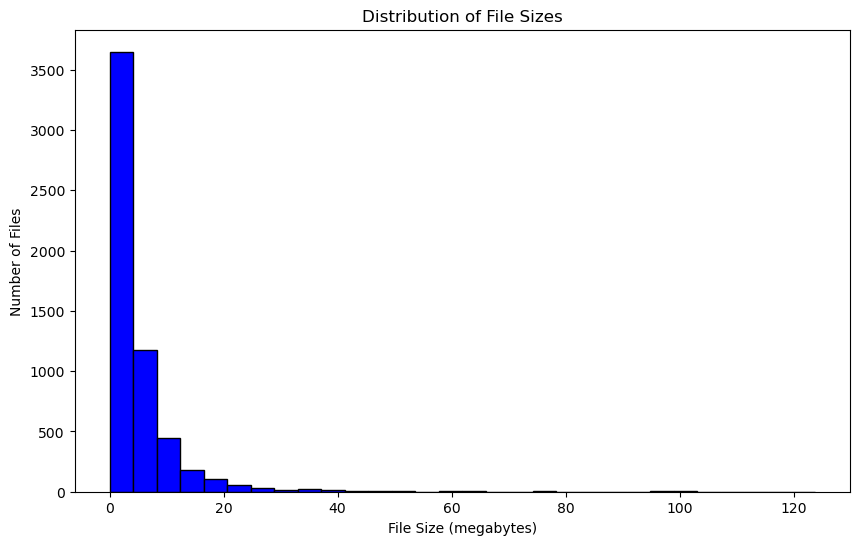

In [7]:
def get_file_sizes(directory, pattern='*'):
    """
    Get sizes of all files in the specified directory matching the pattern.
    """
    search_pattern = os.path.join(directory, pattern)
    files = glob.glob(search_pattern)
    file_sizes = [os.path.getsize(f) for f in files]
    return file_sizes

def plot_size_distribution(file_sizes):
    """
    Plot a histogram of file sizes.
    """

    file_sizes_MB = [size / (1024 * 1024) for size in file_sizes]
    plt.figure(figsize=(10, 6))
    plt.hist(file_sizes_MB, bins=30, color='blue', edgecolor='black')
    plt.title('Distribution of File Sizes')
    plt.xlabel('File Size (megabytes)')
    plt.ylabel('Number of Files')
    plt.show()

# Example usage
file_sizes = get_file_sizes(directory)
plot_size_distribution(file_sizes)


In [ ]:
for file in tqdm(filtered_files[:1000]):
    
    outfile = Path(json_directory) / f"{Path(file).stem}.json" 
    if os.path.isfile(outfile):
        print(f'skipping {Path(file).stem}')
        continue
    out = model.transcribe(file)
    with open(outfile, 'w', encoding='utf-8') as f:
        json.dump(out,f)

In [ ]:
model.detect_language(filtered_files[0])

In [ ]:
def process_batch(batch, model, json_directory):
    # Transcribe the batch
    batch_results = model.transcribe(batch)

    # Iterate through the batch and results simultaneously
    for file, result in zip(batch, batch_results):
        outfile = Path(json_directory) / f"{Path(file).stem}.json"
        with open(outfile, 'w', encoding='utf-8') as f:
            json.dump(result, f)

# Specify your batch size
batch_size = 10

# Process files in batches
for i in tqdm(range(0, len(filtered_files[:1000]), batch_size)):
    batch = filtered_files[i:i + batch_size]

    # Skip entire batch if all output files already exist
    if all(os.path.isfile(Path(json_directory) / f"{Path(file).stem}.json") for file in batch):
        print(f'Skipping batch starting with {Path(batch[0]).stem}')
        continue

    process_batch(batch, model, json_directory)

In [5]:
# instantiate pipeline
pipeline = FlaxWhisperPipline("openai/whisper-medium", dtype=jnp.bfloat16, batch_size=16)

2023-12-19 16:05:24.215833: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
# used cached function thereafter - super fast!!
text = pipeline(filtered_files[0])

In [ ]:
text

In [6]:
print(filtered_files[1])

/data/inet-large-scale-twitter-diffusion/ball4321/data_c/YT/audio/XlGTJ8PWN_I.m4a


In [7]:
%time text2 = pipeline(filtered_files[1])

CPU times: user 2min 30s, sys: 41 s, total: 3min 11s
Wall time: 3min 18s


In [8]:
text2

{'text': " What is the force that causes objects to fall to the ground? Girl, you better. I know this because my titties are low thanks to gravity. Yay! A personal anecdote. Can we just also say we don't actually need gravity? But that's a different thing. Like, I saw someone do this, this was a TikTok, we were watching something where someone's like, we don't actually need gravity. We're watching this to me. Like, we actually don't need it. What do you mean that we don't need gravity? What if it was never invented invented by who sir Isaac Newton Isaac Newton created gravity whoever created gravity if someone did but we don't actually need it"}

In [10]:
%time text3 = pipeline(filtered_files[2])

KeyboardInterrupt: 

In [11]:
text3

NameError: name 'text3' is not defined

In [ ]:
print(filtered_files[:3])

# Analyse completed whisper

In [2]:
import os
from pathlib import Path

def list_files(folder, extension, max_size_mb):
    """List files in a folder with a specific extension and below a size limit."""
    max_size_bytes = max_size_mb * 1024 * 1024
    return {file.stem for file in Path(folder).glob(f'*{extension}')
            if file.stat().st_size <= max_size_bytes}

def compare_folders(folder1, ext1, folder2, ext2, max_size_mb):
    """Compare files in two folders based on their stems."""
    files1 = list_files(folder1, ext1, max_size_mb)
    files2 = list_files(folder2, ext2, max_size_mb)

    unique_to_folder1 = files1 - files2
    unique_to_folder2 = files2 - files1

    return unique_to_folder1, unique_to_folder2

# Example usage
data_base_path = '/data/inet-large-scale-twitter-diffusion/ball4321/data_c/YT'
folder1 = f'{data_base_path}/audio'  # Replace with the path to your first folder
folder2 = f'{data_base_path}/audio_transcribed' # Replace with the path to your second folder
max_size_mb = 50

unique_to_folder1, unique_to_folder2 = compare_folders(folder1, '.m4a', folder2, '.txt', max_size_mb)

print("Unique to folder 1:", unique_to_folder1)
print("Unique to folder 2:", unique_to_folder2)


Unique to folder 1: {'2BZfHX52WJU', 'Vv6DFScEiNo', 'Vu3k0Rriv7U', 'qTa5iDjNTkA', 'QUxtd7EHB6Y', 'QV8upA_89Js', 'QPNij6m4LW0', '28goRUNE71M', 'QQUgxYZ8CdE', '2CiX-6WgSvE', 'QPxGa4Dphgw', '2BJYaiMxndw', '2ACeUU_0Vq8', 'kJsCfT2ZYls', 'JvB4QI9Z7l0', '2CwNI25ZIRc', '2EOMRyrObKs', 'dlGluwmnkpk', 'aomOOXsgtWo', 'VveIeCGWdx8', '29TmBnxmSXo', 'qGZa4azcWg8', 'asqMOcWIu7w', 'QJUS1NiWdWs', 'qN0kJUPo1r0', 'kK0frIbwUXI', 'bU8sxnvDQ04', 'QN0aDbPN1bo', 'qJCKvKBJFf8', '91TedecXh5U', 'kHsrt0Dq68s', 'kIWmJjFCrXc', 'qGNb621vUx4', 'qTd10hwWEbU', 'kI1JM5q6B14', 'bUEJQvR8w5I', 'qHc4ffZBEUc', 'Vrx_ulDoGBI', 'qPBXpSbRJ1Q', 'do21JJ61wHc', 'kHGUaJLn1SU', 'WMnmE-Z3N-g', '2CpUs1rdgn8', 'QMJ08iZmRgI', '28PeVqwIu-I', 'qNGkAGOzkM4', 'dk8Fgko3ryM', 'qPN8rN9siSs', 'QPetKLCfBuQ', '2DPQsxzz3XE', 'QNU5F2gu21E', 'aoY2m5nFbmk', 'QP6mOGAyOL0', 'qM830LYuH_w', 'QQApZhXLcic', 'qR2Q6KpsXKc', 'WMXbzCtZijQ', 'wykPCGmQv9g', '29Yu4xR_-XQ', 'wyYB0v4d2No', '91Jht9p474o', '906_tO-panc', '2AFnVeZ16kY', 'Vw4S3PDlEWg', 'QTDYF0J0SBk', 'qOk

In [11]:
full_path_unique_folder_1 = [f'{data_base_path}/audio/{i}.m4a' for i in unique_to_folder1]

In [12]:
len(full_path_unique_folder_1)

95

In [13]:
with open(f'{data_base_path}/files_remaining.txt', 'w') as f:
    for file in full_path_unique_folder_1:
        f.write(file)
        f.write('\n')